In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np

from contact_graspnet.dataloading import OrigExampleData, YCBSimulationData
from contact_graspnet.preprocessing import Img2CamCoords, Depth2ImgPoints, ZClipper, UniversalPreprocessor, SegmentationBinarizer, Resizer
from contact_graspnet.postprocessing import Postprocessor, TopScoreFilter, Cam2WorldGraspConverter
from contact_graspnet.models import ContactGraspnet
from contact_graspnet.utils.visualization import mlab_pose_vis
from contact_graspnet.utils.misc import get_root_dir, setup_tensorflow

2023-03-06 19:22:31.119822: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 19:22:33.436175: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/moritz/catkin_ws/devel/lib:/opt/ros/noetic/lib:/home/moritz/.mujoco/mujoco210/bin:/home/moritz/mambaforge/envs/contact/lib/:/home/moritz/mambaforge/envs/contact/lib/
2023-03-06 19:22:33.437377: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No

/home/moritz/Documents/ContactGraspnetBenchmark/contact_graspnet/orig/pointnet2/tf_ops/sampling


In [2]:
setup_tensorflow()

In [3]:
dataset = YCBSimulationData(
    Path.home() / "Documents" / "ycb_sim_data_1",
    transform=UniversalPreprocessor(
        depth2points_converter=Depth2ImgPoints(),
        img2cam_converter=Img2CamCoords(),
        z_clipper=ZClipper([0.2, 1.8]),
        # segmentation_binarizer=SegmentationBinarizer(),
    ),
)

010_banana


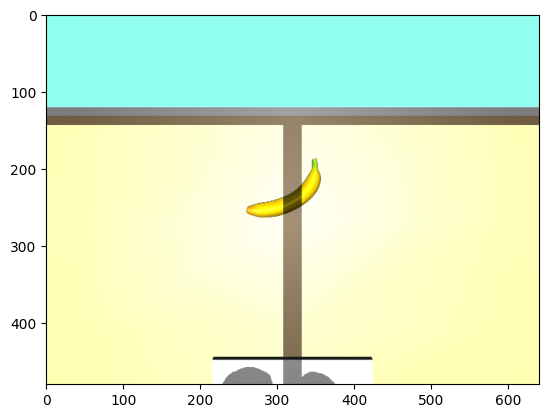

In [4]:
full_pc, segmented_pc = dataset[9]

sample = dataset.transform.intermediate_results["initial_sample"]
print(sample.name)
plt.imshow(sample.rgb)

In [5]:
model = ContactGraspnet(
    get_root_dir()
    / "checkpoints"
    / "scene_test_2048_bs3_hor_sigma_001"
    / "config.yaml",
    get_root_dir() / "checkpoints" / "scene_test_2048_bs3_hor_sigma_001",
)

--- Get model


/home/moritz/Documents/ContactGraspnetBenchmark/contact_graspnet/orig/pointnet2/utils/tf_util.py:571: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  momentum=bn_decay, axis=axis, name=scope,


('loading ', '/home/moritz/Documents/ContactGraspnetBenchmark/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/model.ckpt-54054')


In [6]:
postprocessor = Postprocessor(top_score_filter=None)

In [7]:
network_output = (pred_grasps_cam, scores, contact_pts, widths) = model(full_pc, segmented_pc)

grasps_cam = postprocessor(network_output)

Extracted Region Cube Size:  0.3389807482426991
Generated 59 grasps for object -1


In [8]:
mlab_pose_vis(
    full_pc,
    grasps_cam,
    dataset.transform.intermediate_results["full_pc_colors"],
)